In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('../18-natural-language-processing/smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [6]:
df['length'] = df['message'].apply(len)

In [7]:
import string

In [8]:
from nltk.corpus import stopwords

In [9]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    3. return list of clean text words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['message'])

In [13]:
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x7f8290486ca0>)

In [14]:
print(len(bow_transformer.vocabulary_))

11425


In [15]:
mess4 = df['message'][3]

In [16]:
print(mess4)

U dun say so early hor... U c already then say...


In [17]:
bow4 = bow_transformer.transform([mess4])

In [18]:
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


In [19]:
print(bow4.shape)

(1, 11425)


In [20]:
bow_transformer.get_feature_names()[4068]

'U'

In [21]:
bow_transformer.get_feature_names()[9554]

'say'

In [22]:
messages_bow = bow_transformer.transform(df['message'])

In [23]:
print('Shape of this parse Matrix: ', messages_bow.shape)

Shape of this parse Matrix:  (5572, 11425)


In [24]:
messages_bow.nnz

50548

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

In [26]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [28]:
tfidf4 = tfidf_transformer.transform(bow4)

In [29]:
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [30]:
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

In [32]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [33]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
spam_detect = MultinomialNB().fit(messages_tfidf, df['label'])

In [36]:
spam_detect.predict(tfidf4)[0]

'ham'

In [37]:
all_pred = spam_detect.predict(messages_tfidf)

In [38]:
all_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
msg_train, msg_test, label_train, label_test = train_test_split(df['message'], df['label'], test_size=0.3, random_state=101)

In [42]:
from sklearn.pipeline import Pipeline

In [43]:
pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [44]:
pipe.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f8290486ca0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [45]:
preds = pipe.predict(msg_test)

In [46]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [47]:
print(classification_report(label_test, preds))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1475
        spam       1.00      0.65      0.79       197

    accuracy                           0.96      1672
   macro avg       0.98      0.83      0.88      1672
weighted avg       0.96      0.96      0.96      1672



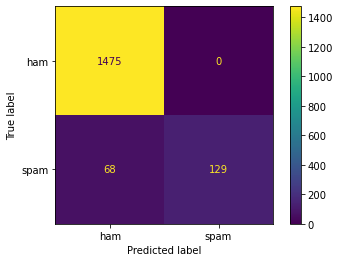

In [48]:
plot_confusion_matrix(pipe, msg_test, label_test)